In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
#importing libraries
import numpy as np 

%matplotlib inline 
#to use as command line calls #using inline graphs will come next to code

import matplotlib.pyplot as plt #for graphs
import os #for operating system dependent fucntionality
from keras import layers #for building layers of neural net
from keras.models import Model
from keras.models import load_model
from keras import callbacks #for training logs, saving to disk periodically
import cv2 #OpenCV(Open Source computer vision lib), containg CV algos
import string

In [3]:
#print images in dataset
os.listdir("/content/drive/My Drive/all_captcha_images")

['3x1=j.jpg',
 '9x2=j.jpg',
 '1x1=j.jpg',
 '0+9=j.jpg',
 '4x5=j.jpg',
 '2-4=j.jpg',
 '7+5=j.jpg',
 '5-2=j.jpg',
 '9-2=j.jpg',
 '0x3=j.jpg',
 '5-1=j.jpg',
 '4+3=j.jpg',
 '6x1=j.jpg',
 '1x0=j.jpg',
 '2x4=j.jpg',
 '4x0=j.jpg',
 '5-3=j.jpg',
 '1+9=j.jpg',
 '7x6=j.jpg',
 '4-4=j.jpg',
 '4x7=j.jpg',
 '1x4=j.jpg',
 '4+0=j.jpg',
 '4-5=j.jpg',
 '0+0=j.jpg',
 '5-6=j.jpg',
 '2x9=j.jpg',
 '0x2=j.jpg',
 '3-2=j.jpg',
 '5-4=j.jpg',
 '0+1=j.jpg',
 '0+5=j.jpg',
 '6-4=j.jpg',
 '2-9=j.jpg',
 '3x9=j.jpg',
 '4x1=j.jpg',
 '5+3=j.jpg',
 '0+2=j.jpg',
 '2x0=j.jpg',
 '4+4=j.jpg',
 '5-0=j.jpg',
 '1-3=j.jpg',
 '4+5=j.jpg',
 '3+3=j.jpg',
 '6+1=j.jpg',
 '3x0=j.jpg',
 '6x9=j.jpg',
 '4x3=j.jpg',
 '2-6=j.jpg',
 '5x2=j.jpg',
 '4+1=j.jpg',
 '2x5=j.jpg',
 '0x9=j.jpg',
 '7x7=j.jpg',
 '2-2=j.jpg',
 '7x4=j.jpg',
 '0x7=j.jpg',
 '4x6=j.jpg',
 '1+2=j.jpg',
 '1-6=j.jpg',
 '9-5=j.jpg',
 '0-6=j.jpg',
 '4-6=j.jpg',
 '9-1=j.jpg',
 '5x0=j.jpg',
 '7x1=j.jpg',
 '9+1=j.jpg',
 '7x5=j.jpg',
 '7x0=j.jpg',
 '0-5=j.jpg',
 '6+9=j.jpg',
 '4-3=

In [4]:
#total no of images in dataset
n=len(os.listdir("/content/drive/My Drive/all_captcha_images"))
n

243

In [5]:
#defining size of image
imgshape=(25,65,1) #25-height, 65-width, 1-no of channels

In [6]:
character = "012345679+-*=?" # All symbols captcha can contain
nchar = len(character) #total number of char possible
nchar

14

In [7]:
#preprocesss image
def preprocess():
  X = np.zeros((n,25,65,1)) #243*25*65 array with all entries 0
  y = np.zeros((5,n,nchar)) #5*243*14(5 letters in captcha) with all entries 0

  for i, pic in enumerate(os.listdir("/content/drive/My Drive/all_captcha_images")):
  #i represents index no. of image in directory 
  #pic contains the file name of the particular image to be preprocessed at a time
    
    img = cv2.imread(os.path.join("/content/drive/My Drive/all_captcha_images", pic), cv2.IMREAD_GRAYSCALE) #Read image in grayscale format
    pic_target = pic[:-4]#this drops the .jpg extension from file name and contains only the captcha for training
    
    if len(pic_target) < 6: #captcha is not more than 5 letters
      img = img / 255.0 #scales the image between 0 and 1
      img = np.reshape(img, (25, 65, 1)) #reshapes image to width 65 , height 25 ,channel 1 

      target=np.zeros((5,nchar)) #creates an array of size 5*14 with all entries 0, (5 is target chars, 14 is total labels)

      for j, k in enumerate(pic_target):
      #j iterates from 0 to 4(5 letters in captcha)
      #k denotes the letter in captcha which is to be scanned
         index = character.find(k) #index stores the position of letter k of captcha in the character string
         target[j, index] = 1 #replaces 0 with 1 in the target array at the position of the letter in captcha

      X[i] = img #stores all the images
      y[:,i] = target #stores all the info about the letters in captcha of all images

  return X,y

In [8]:
#create model
def createmodel():
    img = layers.Input(shape=imgshape) # Get image as an input of size 25,65,1
    conv1 = layers.Conv2D(16, (3, 3), padding='same', activation='relu')(img) #25*65
    mp1 = layers.MaxPooling2D(padding='same')(conv1)  # 13*33
    conv2 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(mp1)
    mp2 = layers.MaxPooling2D(padding='same')(conv2)  # 7*17
    conv3 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(mp2)
    bn = layers.BatchNormalization()(conv3) #to improve the stability of model
    mp3 = layers.MaxPooling2D(padding='same')(bn)  # 4*9
    
    flat = layers.Flatten()(mp3) #convert the layer into 1-D

    outs = []
    for _ in range(5): #for 5 letters of captcha
        dens1 = layers.Dense(64, activation='relu')(flat)
        drop = layers.Dropout(0.5)(dens1) #drops 0.5 fraction of nodes
        res = layers.Dense(nchar, activation='sigmoid')(drop)

        outs.append(res) #result of layers
    
    # Compile model and return it
    model = Model(img, outs) #create model
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=["accuracy"])
    return model

In [9]:
#Create model
model=createmodel();
model.summary();

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 25, 65, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 25, 65, 16)   160         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 13, 33, 16)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 13, 33, 32)   4640        ['max_pooling2d[0][0]']          
                                                                                              

In [10]:
X,y=preprocess()

In [11]:
# Instead of Splitting the Samples, into test/train I am using all the 243 images for testing and training,
# because of very few Samples
X_train, y_train = X, y
X_test, y_test = X, y

In [12]:
#Applying the model
hist = model.fit(X_train, [y_train[0], y_train[1], y_train[2], y_train[3], y_train[4]], batch_size=32, epochs=60, validation_split=0.2)
#batch size- 32 defines no. of samples per gradient update
#Validation split=0.2 splits the training set in 80-20% for training nd testing

Epoch 1/60
7/7 [==============================] - 14s 128ms/step - loss: 9.1494 - dense_1_loss: 2.9162 - dense_3_loss: 1.9211 - dense_5_loss: 2.8132 - dense_7_loss: 0.4230 - dense_9_loss: 1.0758 - dense_1_accuracy: 0.0928 - dense_3_accuracy: 0.2526 - dense_5_accuracy: 0.0928 - dense_7_accuracy: 0.8969 - dense_9_accuracy: 0.7216 - val_loss: 10.9325 - val_dense_1_loss: 2.5777 - val_dense_3_loss: 2.3580 - val_dense_5_loss: 2.5803 - val_dense_7_loss: 1.6539 - val_dense_9_loss: 1.7626 - val_dense_1_accuracy: 0.1020 - val_dense_3_accuracy: 0.3061 - val_dense_5_accuracy: 0.1224 - val_dense_7_accuracy: 1.0000 - val_dense_9_accuracy: 1.0000
Epoch 2/60
7/7 [==============================] - 0s 13ms/step - loss: 6.9264 - dense_1_loss: 2.6541 - dense_3_loss: 1.5506 - dense_5_loss: 2.6729 - dense_7_loss: 0.0105 - dense_9_loss: 0.0383 - dense_1_accuracy: 0.1186 - dense_3_accuracy: 0.3866 - dense_5_accuracy: 0.1237 - dense_7_accuracy: 0.9948 - dense_9_accuracy: 0.9845 - val_loss: 10.1324 - val_dense_

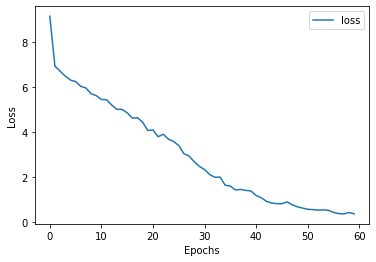

In [13]:
#graph of loss vs epochs
for label in ["loss"]:
  plt.plot(hist.history[label],label=label)
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [15]:
# Check all Possible Graphs That we can generate from data
hist.history.keys()

dict_keys(['loss', 'dense_1_loss', 'dense_3_loss', 'dense_5_loss', 'dense_7_loss', 'dense_9_loss', 'dense_1_accuracy', 'dense_3_accuracy', 'dense_5_accuracy', 'dense_7_accuracy', 'dense_9_accuracy', 'val_loss', 'val_dense_1_loss', 'val_dense_3_loss', 'val_dense_5_loss', 'val_dense_7_loss', 'val_dense_9_loss', 'val_dense_1_accuracy', 'val_dense_3_accuracy', 'val_dense_5_accuracy', 'val_dense_7_accuracy', 'val_dense_9_accuracy'])

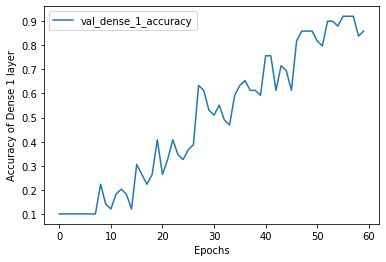

In [16]:
#graph of accuracy of dense_1 vs epochs
for label in ["val_dense_1_accuracy"]:
  plt.plot(hist.history[label],label=label)
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy of Dense 1 layer")
plt.show()

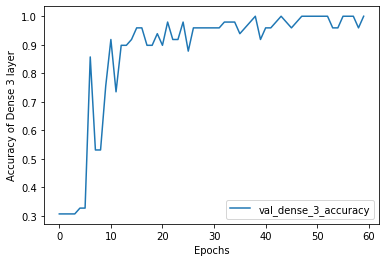

In [17]:
#graph of accuracy of dense_3 vs epochs
for label in ["val_dense_3_accuracy"]:
  plt.plot(hist.history[label],label=label)
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy of Dense 3 layer")
plt.show()

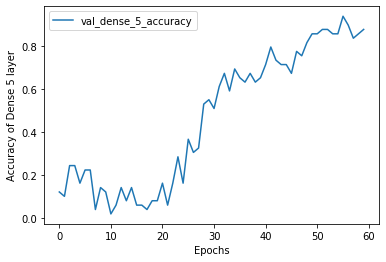

In [18]:
#graph of accuracy of dense_5 vs epochs
for label in ["val_dense_5_accuracy"]:
  plt.plot(hist.history[label],label=label)
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy of Dense 5 layer")
plt.show()

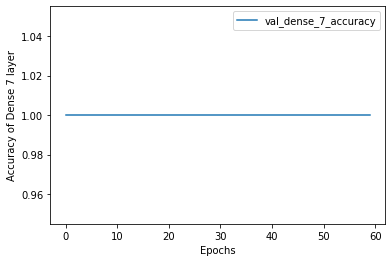

In [19]:
#graph of accuracy of dense_7 vs epochs
for label in ["val_dense_7_accuracy"]:
  plt.plot(hist.history[label],label=label)
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy of Dense 7 layer")
plt.show()

In [20]:
# Loss on training set
# Finding Loss on training set
preds = model.evaluate(X_train, [y_train[0], y_train[1], y_train[2], y_train[3], y_train[4]])
print ("Loss on training set= " + str(preds[0]))

8/8 [==============================] - 0s 15ms/step - loss: 0.9037 - dense_1_loss: 0.4190 - dense_3_loss: 0.0842 - dense_5_loss: 0.3972 - dense_7_loss: 3.4632e-04 - dense_9_loss: 0.0031 - dense_1_accuracy: 0.9712 - dense_3_accuracy: 1.0000 - dense_5_accuracy: 0.9753 - dense_7_accuracy: 0.9959 - dense_9_accuracy: 0.9959
Loss on training set= 0.9037339091300964


In [29]:
#Finding loss on test set, Will be Same Because of same samples as training set
preds = model.evaluate(X_test, [y_test[0], y_test[1], y_test[2], y_test[3], y_test[4]])
print ("Loss on testing set= " + str(preds[0]))

8/8 [==============================] - 0s 6ms/step - loss: 0.9037 - dense_1_loss: 0.4190 - dense_3_loss: 0.0842 - dense_5_loss: 0.3972 - dense_7_loss: 3.4632e-04 - dense_9_loss: 0.0031 - dense_1_accuracy: 0.9712 - dense_3_accuracy: 1.0000 - dense_5_accuracy: 0.9753 - dense_7_accuracy: 0.9959 - dense_9_accuracy: 0.9959
Loss on testing set= 0.9037339091300964


In [25]:
#to predict captcha
def predict(filepath):
    img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)

    if img is not None: #image found at file path
        img = img / 255.0 #Scale image
    else:
        print("Not detected")
        return False

    res = np.array(model.predict(img[np.newaxis, :, :, np.newaxis])) #np.newaxis=1 
    #added this bcoz x_train 243*25*65*1
    #returns array of size 1*5*14 
    result = np.reshape(res, (5, 14)) #reshape the array
    k_ind = []
    probs = []
    for i in result:
        k_ind.append(np.argmax(i)) #adds the index of the char found in captcha

    capt = '' #string to store predicted captcha
    for k in k_ind:
        capt += character[k] #finds the char corresponding to the index
    
    if not capt:
        return False
    else:
        # Removing the ? from the end to get mathematical equation
        cleaned_captcha_characters = capt.split("=")[0]

        # Replacing ? from operator because * is too much noisy and model,
        # is predicting ? for * operator most of the time
        cleaned_captcha_characters = cleaned_captcha_characters.replace('?','*')

        # Solve the Mathematical Equation to get the result
        result = eval(cleaned_captcha_characters)
        
        return {"captcha_characters": cleaned_captcha_characters, "result": result}

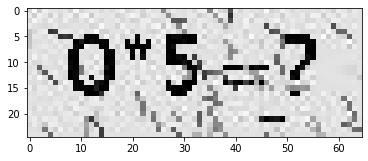

In [23]:
#Check model on samples
img=cv2.imread('/content/drive/My Drive/all_captcha_images/0x5=j.jpg',cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap=plt.get_cmap('gray'))


In [30]:
print("Predicted Captcha =",predict('/content/drive/My Drive/all_captcha_images/0x5=j.jpg'))

Predicted Captcha = {'captcha_characters': '0*5', 'result': 0}


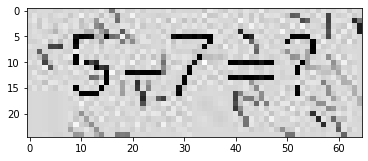

In [27]:
#Sample 2
img=cv2.imread('/content/drive/My Drive/all_captcha_images/5-7=j.jpg',cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap=plt.get_cmap('gray'))

In [28]:
print("Predicted Captcha =",predict('/content/drive/My Drive/all_captcha_images/5-7=j.jpg'))

Predicted Captcha = {'captcha_characters': '5-7', 'result': -2}


In [33]:
#Saving the model
model.save('/content/drive/My Drive/Captcha_Solver/Captcha_Model')

INFO:tensorflow:Assets written to: /content/drive/My Drive/Captcha_Solver/Captcha_Model/assets


In [34]:
# Load the Saved Model
loaded_model = load_model('/content/drive/My Drive/Captcha_Solver/Captcha_Model')